In [3]:
import os
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras 
from sklearn.model_selection import train_test_split
import tensorflow 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import InputLayer, BatchNormalization,Activation, MaxPool2D
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.resnet50 import ResNet50
import tqdm
import keras
import glob
import cv2
import warnings
from keras.preprocessing import image
import numpy as np
warnings.filterwarnings("ignore")
import scipy
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))
seed = 1842
tensorflow.random.set_seed(seed)
np.random.seed(seed)

Num GPUs Available:  0


In [2]:
batch_size=60
img_size=(224,224)
image_generator = ImageDataGenerator(rescale=1/255., validation_split=0) #shear_range =.25, zoom_range =.2, horizontal_flip = True, rotation_range=20)     
train_data = image_generator.flow_from_directory(batch_size=batch_size,directory='F:\Alzheimer_s Dataset\\train',shuffle=True,target_size=img_size, subset="training",class_mode='categorical')

image_generator = ImageDataGenerator(rescale=1/255,validation_split=0.2) 
validation_data= image_generator.flow_from_directory(batch_size=batch_size,directory='F:\Alzheimer_s Dataset\\test',shuffle=True,target_size=img_size,class_mode='categorical')

submission = image_generator.flow_from_directory(directory='F:\Alzheimer_s Dataset\\test',shuffle=False,subset="validation",target_size=img_size, class_mode=None)

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Found 254 images belonging to 4 classes.


In [4]:
train_data.class_indices

{'MildDemented': 0,
 'ModerateDemented': 1,
 'NonDemented': 2,
 'VeryMildDemented': 3}

In [5]:
batch_size=60
epoch=10
callback= keras.callbacks.EarlyStopping(monitor='val_loss',patience=8,restore_best_weights=True)

In [6]:
rn50 = ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)
for layer in rn50.layers:
    layer.trainable = False
x = Flatten()(rn50.output)
x = Dense(128, activation='relu')(x)
out = Dense(4, activation='softmax')(x)

modelrn50= Model(inputs=rn50.input, outputs=out)

#compiling
modelrn50.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])
#Summary
modelrn50.summary()

94765736/94765736 [==============================] - 27s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                        

In [8]:
hist_rn50=modelrn50.fit(train_data, epochs=epoch, validation_data=validation_data, callbacks=callback)

Epoch 1/10
86/86 [==============================] - 926s 11s/step - loss: 1.0281 - accuracy: 0.5108 - val_loss: 1.0104 - val_accuracy: 0.5059
Epoch 2/10
86/86 [==============================] - 401s 5s/step - loss: 0.9795 - accuracy: 0.5296 - val_loss: 1.0024 - val_accuracy: 0.5254
Epoch 3/10
86/86 [==============================] - 412s 5s/step - loss: 0.9480 - accuracy: 0.5466 - val_loss: 0.9810 - val_accuracy: 0.5215
Epoch 4/10
86/86 [==============================] - 599s 7s/step - loss: 0.9209 - accuracy: 0.5651 - val_loss: 0.9926 - val_accuracy: 0.5238
Epoch 5/10
86/86 [==============================] - 506s 6s/step - loss: 0.9246 - accuracy: 0.5569 - val_loss: 0.9772 - val_accuracy: 0.5152
Epoch 6/10
86/86 [==============================] - 654s 8s/step - loss: 0.8939 - accuracy: 0.5811 - val_loss: 0.9751 - val_accuracy: 0.5152
Epoch 7/10
86/86 [==============================] - 582s 7s/step - loss: 0.8998 - accuracy: 0.5743 - val_loss: 0.9617 - val_accuracy: 0.5387
Epoch 8/10
8

In [9]:
loss_rn50,accuracy_rn50= modelrn50.evaluate(validation_data)

22/22 [==============================] - 74s 3s/step - loss: 1.0014 - accuracy: 0.4996


In [10]:
batch_size = 1
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('F:\Alzheimer_s Dataset\\test',color_mode = "rgb",target_size=(224, 224),batch_size=1, shuffle=True)
y_pred = modelrn50.predict_generator(test_generator, 1//batch_size, workers=4)

Found 1279 images belonging to 4 classes.


In [11]:
label_dict = {0: 'MildDemented', 1: 'ModerateDemented',2: 'NonDemented', 3: 'VeryMildDemented'}

1/1 [==============================] - 1s 1s/step
[[0.26082167 0.0022219  0.19660552 0.5403509 ]]


Text(0.5, 1.0, 'VeryMildDemented')

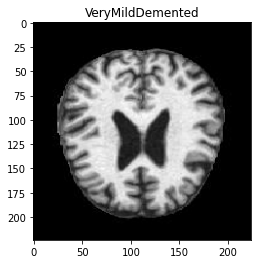

In [12]:
x_test, y_test = next(test_generator)
p = modelrn50.predict(x_test)
print(p)
p = p.argmax()
plt.imshow(x_test[0])
plt.title(label_dict[p])

In [13]:
path="F:\Alzheimer_s Dataset\\train\MildDemented\\mildDem0.jpg"
img=image.load_img(path,target_size=(224,224))

img=image.img_to_array(img)/224
img=np.array([img])
img.shape

(1, 224, 224, 3)

In [14]:
Y_pred = modelrn50.predict_generator(validation_data, 1000 // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_data.classes, y_pred))
print('Classification Report')
target_names = ['MildDemented',  'ModerateDemented','NonDemented', 'VeryMildDemented']
print(classification_report(validation_data.classes, y_pred, target_names=target_names))

Confusion Matrix
[[  0   0  43 136]
 [  0   0   3   9]
 [  0   0 148 492]
 [  0   0 120 328]]
Classification Report
                  precision    recall  f1-score   support

    MildDemented       0.00      0.00      0.00       179
ModerateDemented       0.00      0.00      0.00        12
     NonDemented       0.47      0.23      0.31       640
VeryMildDemented       0.34      0.73      0.46       448

        accuracy                           0.37      1279
       macro avg       0.20      0.24      0.19      1279
    weighted avg       0.35      0.37      0.32      1279

